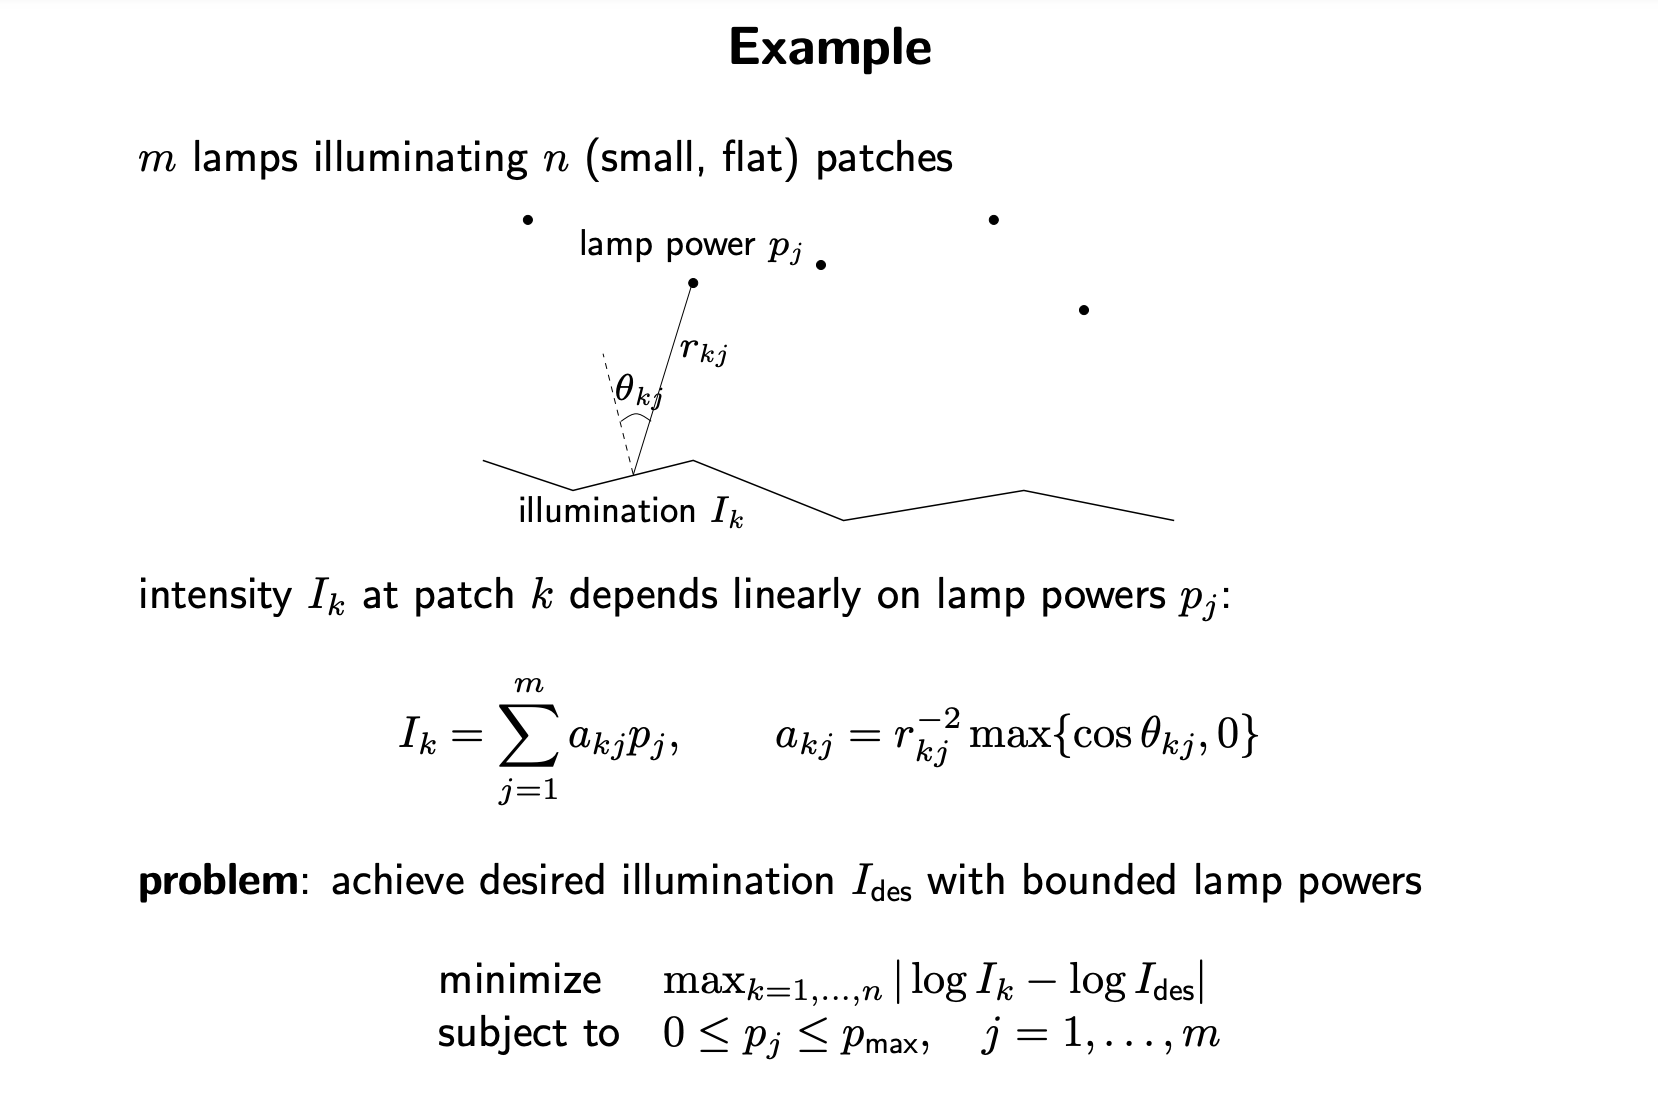


## Problem data

* There are 10 lamps ($m = 10$) and 20 patches ($n = 20$).
* $p \in \mathbb{R}^m$ is our problem variables, where $p_j$ is the power of lamp $j$.
* Let's consider the matrix $A \in \mathbb{R}^{n \times m}$ where $A_{ij}$ defines the incidence ($a_{ij}$) of lamp $j$ on patch $i$. The matrix A is stored in the data/illum_data.csv.
* We take $I_{des}=1$ and $p_{max}=1$.

In [4]:
# Import libraries
%matplotlib inline
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import matplotlib.pyplot as plt



In [5]:
# Load Data
A = np.loadtxt('./illum_data.csv', delimiter=',')
n, m = A.shape
Ides = 1
pmax = 1

print("A defines the geometry for n={} patches and m={} lamps".format(n,m))

A defines the geometry for n=20 patches and m=10 lamps


## Problem Description

We can express the general illumination problem as,
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \text{max}_{k=1,\ldots,n} \mid log~I_k - log~I_{des}\mid \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

Our data, however, allows simplifications of the objective $f_0(\dot) $ of our problem,

\begin{equation*}
\begin{aligned}
f_0(p) &= \text{max}_{k=1,\ldots,n} \mid log~I_k - log~I_{des}\mid & (log~I_{des} = log~1 = 0)\\
& = \text{max}_{k=1,\ldots,n} \mid log~I_k\mid  & (\mid log~I_{des} \mid = log~I_{des}~\text{or}~-log~I_{des} = log~I_{des}^{-1})\\
& = \text{max}_{k=1,\ldots,n} \text{max} \left\{ log~I_k, log~(1 / I_k) \right\} & (\text{log function is monotonically increasing})\\
& = log~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} &
\end{aligned}
\end{equation*}

Then our problem can be described as,
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & log~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}
which is a convex optimizations problem, since logarithm is a monotonically increasing function and we are minimizing a pointwise maximum of linear functions.

Therefore, we will compute several approximate solutions, and compare the results to the exact solution, for our specific problem instance.




### Approximate solutions:


---


#### 1 - Use uniform power
Take $p_j = \lambda$ for $j = 1,\ldots,m$, vary $\lambda \in [0, p_{max}]$ and compute $f_0(p)$. Then, pick the $\lambda$ as the one which gives the smallest value of $f_0(p)$.

In [2]:
# The maximum difference to the desired ilumination
def obj(p):
    return np.max(np.abs(np.log(np.dot(A,p) + 1e-8)), axis=0)


Best solution p* = [0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36]
Best objective f0* = 0.50


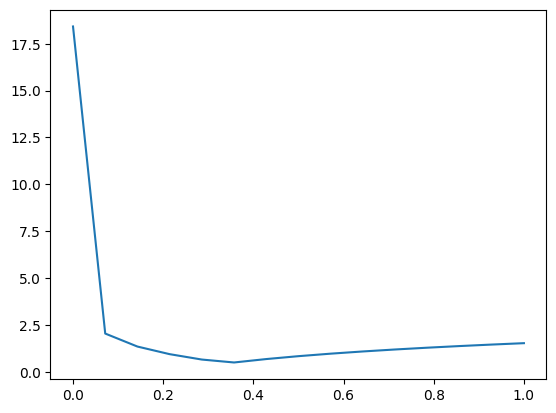

In [6]:
num_vals = 15
lamb = np.linspace(0, pmax, num=num_vals)
ps = np.dot(np.ones((m,1)), lamb.reshape(1, num_vals))
f0s = obj(ps)
plt.plot(lamb, f0s)


idx = np.argmin(f0s)
p_uni = np.ones(m) * lamb[idx]
f0_uni = f0s[idx]
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_uni, f0_uni))



---


#### 2 -  Least-squares with saturations:
solve the least-squares problem, (i.e., $\text{minimize}~\mid\mid Ap - I_{des}\mid\mid^2_2$) and clip the solution $p_j$ values between $[0,p_{max}]$.



> NUMPY



In [11]:
p_ls, _, _, _ = np.linalg.lstsq(A, np.ones(n) * Ides, rcond=None)
p_ls = np.clip(p_ls, 0, pmax)
f0_ls = obj(p_ls)
print("Best solution p*={}\nBest objective f0*={:.2f}".format(p_ls, f0_ls))

Best solution p*=[1. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
Best objective f0*=0.86


> CVXPY

In [13]:
import cvxpy as cp
import numpy as np

In [14]:
b = np.ones(n)*Ides
P = cp.Variable(m)

cost = cp.norm2(A @ P - b)**2
objective = cp.Minimize(cost)

prob = cp.Problem(objective)
result = prob.solve()

print(P.value)
p_ls = np.clip(P.value, 0, pmax)
f0_ls = obj(p_ls)
print("Best solution p*={}\nBest objective f0*={:.2f}".format(p_ls, f0_ls))

[  6248.19  -5212.84    126.41   -281.76  -8237.94  11187.95 -11744.92
  12156.34  -6095.     1347.08]
Best solution p*=[1. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
Best objective f0*=0.86




> SKLEARN / Regression


In [15]:
from sklearn.linear_model import LinearRegression


In [16]:
model = LinearRegression(fit_intercept=False)

model.fit(A, b)

print(model.coef_)

p_ls = np.clip(model.coef_, 0, pmax)
f0_ls = obj(p_ls)
print("Best solution p*={}\nBest objective f0*={:.2f}".format(p_ls, f0_ls))

[  6054.81  -5099.41    125.75   -279.15  -6773.47   9629.7  -12553.9
  13347.92  -6238.59   1274.47]
Best solution p*=[1. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
Best objective f0*=0.86




---


#### 3 - Regularized least-squares:
Solve regularized least-sqaures problems (i.e., $\text{minimize}~\mid\mid Ap - I_{des}\mid\mid^2_2 + \lambda \mid\mid p - 0.5p_{max} \mid\mid^2_2$) increasing the value of $\lambda \geq 0$ until the solution $p$ values are in the interval $[0, p_{max}]$.

In [17]:
lambs = np.linspace(1e-3, 1, num=15);
ps, norms = [], []
for lamb in lambs:
    cofs = np.vstack((A, np.sqrt(lamb)*np.eye(m)))
    tgs = np.vstack((np.ones((n,1))*Ides, np.sqrt(lamb)*0.5*np.ones((m,1))*pmax))
    p, _, _, _ = np.linalg.lstsq(cofs, tgs, rcond=None)
    ps.append(p.ravel())
    norms.append(np.linalg.norm(p.ravel() - 0.5, ord=np.inf))
ps = np.array(ps)
norms = np.array(norms)
idx = np.where(norms <= 0.5)[0][0]
p_rls = ps[idx]
f0_rls = obj(p_rls)
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_rls, f0_rls))

Best solution p* = [0.48 0.46 0.08 0.04 0.44 0.43 0.45 0.43 0.4  0.45]
Best objective f0* = 0.45




---


#### 4 - Chebyshev approximation(linear programming):
Solve the problem,
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \text{max}_{k=1,\ldots,n} \mid I_k - I_{des}\mid \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

We can think of this problem as obtained by approximating the nonlinear function $f_0$ by a piecewise-linear function.

In [ ]:
from cvxpy import *

In [ ]:
p = Variable(m)
cost = Minimize(norm(A@p - Ides, 'inf'))
const = [p >= 0, p <= pmax]
prob = Problem(cost, const)
prob.solve()

p_ch = np.ravel(p.value)
f0_ch = obj(p_ch)
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_ch, f0_ch))

Best solution p* = [1.   0.12 0.   0.   1.   0.   1.   0.02 0.   1.  ]
Best objective f0* = 0.42




---


### 5- Exact solutions
Solve the problem,

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & ~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

In [ ]:
#This section is for you to complete. The final answers should be in the following format:
#Best solution p* = [1.   0.2  0.   0.   1.   0.   1.   0.19 0.   1.  ]
#Best objective f0* = 0.36




---


### Results

The exact solution reaches the smallest objective which measures how close we are to the desired illumination $I_des$. The results are summarized in the following table,

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

index = ['f0(p)']
index.extend(["p{}".format(i) for i in range(m)])

d = {'Uniform' : pd.Series([f0_uni] + p_uni.tolist(), index=index),
    'Least-Square' : pd.Series([f0_ls] + p_ls.tolist(), index=index),
    'Reg-Least-Square' : pd.Series([f0_rls] + p_rls.tolist(), index=index),
    'Chebyshev' : pd.Series([f0_ch] + p_ch.tolist(), index=index),
    'Exact' : pd.Series([f0_ex] + p_ex.tolist(), index=index)
    }
df = pd.DataFrame(d)
df

,Uniform,Least-Square,Reg-Least-Square,Chebyshev,Exact
f0(p),0.501,0.863,0.446,0.420,0.357
p0,0.357,1.000,0.476,1.000,1.000
p1,0.357,0.000,0.455,0.116,0.202
p2,0.357,1.000,0.080,0.000,0.000
p3,0.357,0.000,0.038,0.000,0.000
p4,0.357,0.000,0.444,1.000,1.000
p5,0.357,1.000,0.427,0.000,0.000
p6,0.357,0.000,0.450,1.000,1.000
p7,0.357,1.000,0.426,0.025,0.188
p8,0.357,0.000,0.404,0.000,0.000
